# Intro

In this example, I am using LangChain to build a simple LLM-powered assistant. I will focus on using:
1. Google Gemini
2. OpenAI gpt-4o-mini

In [12]:
# !pip install -qU \
#   langchain-core==0.3.33 \
#   langchain-openai==0.3.3 \
#   langchain-community==0.3.16

# Initialize LLM

First need to initialize an LLM. I'll use _Google Gemini_ or _OpenAI 'gpt-4.1-nano'_ model. You can get an API key from [OpenAI](https://platform.openai.com/settings/organization/api-keys).

In [13]:
AI_Provider = "GOOGLE"
# LLM_Provider = "OPENAI"

if AI_Provider == "GOOGLE":
    llm_model = "gemini-2.0-flash"
elif AI_Provider == "OPENAI":
    llm_model = "gpt-4.1-nano"  # less expensive than gpt-4o-mini

In [14]:
from dotenv import load_dotenv
import os
from getpass import getpass


load_dotenv()  # Try to load local .env file (for local dev); silently skip if not found (for CI)
os.environ[f"{AI_Provider}_API_KEY"] = os.getenv(f"{AI_Provider}_API_KEY") or getpass(f"Enter {AI_Provider} API Key: ")  # Get API key from environment or user input
if os.getenv(f"{AI_Provider}_API_KEY") is None:
    raise ValueError(f"❌ {AI_Provider}_API_KEY not found. Make sure it's in your .env file or set as a GitHub Action secret.")
else:
    print(f"✅ {AI_Provider}_API_KEY loaded successfully (not printing it for security).")

✅ GOOGLE_API_KEY loaded successfully (not printing it for security).


In [15]:
if AI_Provider == "GOOGLE":
    from langchain_google_genai import ChatGoogleGenerativeAI as ChatLLM
elif AI_Provider == "OPENAI":
    from langchain_openai import ChatOpenAI as ChatLLM

llm = ChatLLM(temperature=0.0, model=llm_model)  # For normal accurate responses
# print("✅", llm.invoke("What LLM version are you?").content)

# Problem Setting

I'll take a `new_report.txt`, `metrics.csv`, and `training_examples.csv` and use LangChain to:
1. Score the new report
2. Extract from the new_report 3 pieces of supporting evidence for this Score

# Create VectorDB from TXT

In [8]:
# Read the IBM report file into a string
with open('data/new_report_IBM.txt', 'r', encoding='utf-8') as file:
    report = file.read()
print("Report loaded successfully!")
print(f"Report length: {len(report)} characters")
print("First 200 characters of the report:")
print(report[:200] + "...")

Report loaded successfully!
Report length: 2591 characters
First 200 characters of the report:
Balanced Power of IBM

IBM’s latest sustainability report opens with a bold statement: “IBM is committed to achieving net-zero GHG Scope 1 emissions by 2050 through a comprehensive, three-phase decarb...


In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter  # to split YouTube transcript into chunks
from langchain_core.documents import Document

documents = [Document(page_content=report)]  # wrap the report string in a Document
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=50)  # initilize the text splitter
docs = text_splitter.split_documents(documents)  # split report into overlapping chunks

# # test
# print(f'Test: docs[0].page_content:\n{docs[0].page_content}')
# for i, doc in enumerate(docs):
#     print(f'Test: docs[{i}].page_content:\n{doc.page_content}')

In [23]:
from langchain_huggingface import HuggingFaceEmbeddings  # Alternative:  from langchain.embeddings.openai import OpenAIEmbeddings
    # Try:          from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")  # This model is small (~80MB), fast on CPU, good for English # Alternative: ultra-fast memory-light (~45MB): model_name="sentence-transformers/paraphrase-MiniLM-L3-v2" # Alternative: embeddings = OpenAIEmbeddings()
# Test: one embed string
embed_test = embeddings.embed_query("What company is the report about?")
print(f'Test: len(embeddings)={len(embed_test)}, embeddings[:5]={embed_test[:5]}')  # Should return a 384-dim vector


d:\_DT\Prog\_MyCode\ed_AI_2025\PortfolioGenAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test: len(embeddings)=384, embeddings[:5]=[-0.07845060527324677, 0.08032360672950745, -0.08331143110990524, 0.07523699849843979, 0.028266342356801033]


In [25]:
from langchain_community.vectorstores import FAISS  # Vector Database (indexes); alternatives: Pinecon, Weaviate
db = FAISS.from_documents(docs, embeddings)  # create a DB of vector embeddings from the docs


In [ ]:
def make_vectordb_from_report(report_filename: str) -> FAISS:
    return db # TODO: Implement this function


# NEXT

In [33]:
import pandas as pd
metrics_filename = 'data/metrics.csv'
metrics = pd.read_csv(metrics_filename)
metrics.head()
# print(metrics.MetricDescription[0])

,MetricID,MetricName,MetricDescription
0,1,GHG S1 2050,Score 1: The company claims GSG S1 is going to...
1,2,Athlete,Score 1: Run 100 meters in more than 15 second...
2,3,Educated,Score 1: Knows mathematic.\nScore 2: Knows phy...


In [41]:
for i in range(len(metrics)):
    print(metrics.iloc[i].to_dict())

{'MetricID': 1, 'MetricName': 'GHG S1 2050', 'MetricDescription': 'Score 1: The company claims GSG S1 is going to be zero by 2050, but does not show how it will happen period by period.\nScore 2: The company claims GSG S1 is going to be zero by 2050 and shows how it will happen period by period, but have not done the first step.\nScore 3: The company claims GSG S1 is going to be zero by 2050 and shows how it will happen period by period, and has completed the first step.'}
{'MetricID': 2, 'MetricName': 'Athlete', 'MetricDescription': 'Score 1: Run 100 meters in more than 15 seconds.\nScore 2: Run 100 meters in 15 seconds and can do 40 pushups.\nScore 3: Run 100 meters in 15 seconds, can do 40 pushups, and 60 jumps.'}
{'MetricID': 3, 'MetricName': 'Educated', 'MetricDescription': 'Score 1: Knows mathematic.\nScore 2: Knows physics.\nScore 3: Knows phylosophy.'}


In [ ]:
train_examples_filename = 'data/train_examples.csv'
train_examples = pd.read_csv(train_examples_filename)
train_examples.head()

MetricID = 1
train_examples[train_examples.MetricID == MetricID]


,Company,MetricID,Score,Reason1,Reason2,Reason3
0,PG,1,3,PG will achive net zero by 2050 though 1 initi...,This will allow GHG S1 to reach the following ...,PG has already reached the folloing GHG S1 lev...
3,TCCC,1,2,TCCC will get to net zero by 2050 via 3 initia...,It'll allow GHG S1 to reach these levels: 2020...,"TCCC hit these GHG S1 levels: 2020 - 200 tons,..."
6,GM,1,1,GM will defiintely reach net zero by 2050.,We are brainstorming how we will get to net ze...,So far nothing has been done to achive net zero.


In [52]:
train_examples.iloc[0].to_json()

'{"Company":"PG","MetricID":1,"Score":3,"Reason1":"PG will achive net zero by 2050 though 1 initiative.","Reason2":"This will allow GHG S1 to reach the following levels: 2020 - 50 tons, 2025 - 40 tons, 2035 - 20 tons, 2045 - 10 tons, 2050 - 0 tons.","Reason3":"PG has already reached the folloing GHG S1 levels: 2020 - 49 tons, 2025 - 39 tons."}'

In [ ]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template('You are a sustainability consultant tasked to score a company againset the provided metric. Score can be: 1, 2, or 3.')

# the user prompt is provided by the user, in this case however the only dynamic input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """
    Metric name: {metric_name}
    Scoring criteria:\n{metric_description}

    You need to score the company "{new_company}" against this metric and provide 3 reasons for the score.
    The output should be a JSON object with the following fields (no other explanation or text or fields are allowed):
    - Company: the name of the company
    - Score: the score of the company
    - Reasons1: first reason for the score
    - Reasons2: second reason for the score
    - Reasons3: third reason for the score

    Example of output:
    {
        "Company": "Company name",
        "Score": 1,
        "Reasons1": "Reason 1",
        "Reasons2": "Reason 2",
        "Reasons3": "Reason 3"
    }

    Below are examples of the scoring applied to 3 companies:
    Company 1: {company1}
    Score: {score1}
    Reason 1: {reason1_1}
    Reason 2: {reason1_2}
    Reason 3: {reason1_3}

    Company 2: {company2}
    Score: {score2}
    Reason 1: {reason2_1}
    Reason 2: {reason2_2}
    Reason 3: {reason2_3}

    Company 3: {company3}
    Score: {score3}
    Reason 1: {reason3_1}
    Reason 2: {reason3_2}
    Reason 3: {reason3_3}""",
    input_variables=["metric_name", "metric_description", "new_company",
        "company1", "score1", "reason1_1", "reason1_2", "reason1_3",
        "company2", "score2", "reason2_1", "reason2_2", "reason2_3",
        "company3", "score3", "reason3_1", "reason3_2", "reason3_3"]
)



# Main Code

## Step1

In [38]:
user_prompt.format(metric_name="GHG Scope1current", "metric_description"=, "new_company",
        "company1", "score1", "reason1_1", "reason1_2", "reason1_3",
        "company2", "score2", "reason2_1", "reason2_2", "reason2_3",
        "company3", "score3", "reason3_1", "reason3_2", "reason3_3")

HumanMessage(content='You need to create a name for the article below:\n\n---\n\nTEST STRING\n\n---\n\nThe name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.\n\nOutput only 1 article name, no other explanation or text can be provided.', additional_kwargs={}, response_metadata={})

Now we can merge the system and user prompts into a full chat prompt using the `ChatPromptTemplate`:

In [39]:
from langchain.prompts import ChatPromptTemplate

# prompt template 1: create an article title
prompt1 = ChatPromptTemplate.from_messages([system_prompt, user_prompt1])

By default, the `ChatPromptTemplate` will read the `input_variables` from each of the prompt templates inserted and allow us to use those input variables when formatting the full chat prompt template:

In [40]:
print(prompt1.format(article="TEST STRING"))

System: You are an AI assistant that helps generate article titles, summaries, and paragraphs.
Human: You need to create a name for the article below:

---

TEST STRING

---

The name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.

Output only 1 article name, no other explanation or text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

In [41]:
prompt1.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an AI assistant that helps generate article titles, summaries, and paragraphs.'), additional_kwargs={}),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['article'], input_types={}, partial_variables={}, template='You need to create a name for the article below:\n\n---\n\n{article}\n\n---\n\nThe name should be based of the context of the article. Make sure the name is clear, catchy, and relevant to the article theme.\n\nOutput only 1 article name, no other explanation or text can be provided.'), additional_kwargs={})]

Now chain the `first_prompt` template and the `llm` object defined earlier to create an LLM chain for **prompt formatting > llm generation > get output**.

Let's use __LCEL__ to construct the chain: define inputs with `{"article": lambda x: x["article"]}` and use the pipe operator (`|`) to feed the output from its left into the input to its right.

In [42]:
# chain1: inputs:article / output:article_title
chain1 = (
    {"article": lambda x: x["article"]}
    | prompt1
    | llm_creative
    | {"article_title": lambda x: x.content}
)

This first chain creates an article title:

In [43]:
article_title_msg = chain1.invoke({"article": article})
article_title_msg

{'article_title': '**Title:** Speeding Up Insurance Risk Projections by 100x'}

This __Step1__ will be chained with other `LLMChain` steps.

## Step2

__Step2__ will summarize the article using the `article` and the newly generated `article_title`, and it'll output a new `summary` variable:

In [44]:
user_prompt2 = HumanMessagePromptTemplate.from_template(
    """You need to create a description for the article below:

---

{article}

---

Here is the article title '{article_title}'.

Output a SEO friendly article description. Do not output anything other than a description.""",
    input_variables=["article", "article_title"]
)

# prompt template 2: summarize the article
prompt2 = ChatPromptTemplate.from_messages([
    system_prompt,
    user_prompt2
])

In [45]:
# chain2: inputs:article,article_title / output:summary
chain2 = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    | prompt2
    | llm_conservative
    | {"summary": lambda x: x.content}
)

In [46]:
article_description_msg = chain2.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"]
})
article_description_msg

{'summary': "A case study on how to speed up a large life insurance client's financial projection model by 100x. The original model used stochastic Monte Carlo simulation and actuarial adjustments to simulate interest rate and GDP growth shocks, but was too slow for ad-hoc risk analysis. Learn how we built a scalable system that maintained 0.95+ accuracy."}

## Step3

__Step3__ will take the initial `article` and output _several fields_ that help the user to improve their writing. Since it outputs many fields we'll specify for the LLM to use __structured outputs__ to keeping the generated fields aligned with our requirements.

In [47]:
user_prompt3 = HumanMessagePromptTemplate.from_template(
    """You need to create a new paragraph for the article below:

---

{article}

---

Choose 1 paragraph to review and edit. As you edit, provide feedback to the user
for them to improve their writing.""",
    input_variables=["article"]
)

# prompt template 3: create a new article paragraph 
prompt3 = ChatPromptTemplate.from_messages([
    system_prompt,
    user_prompt3
])

To make the generated fields aligned with our requirements, we'll tell the LLM to use __structured outputs__. For this we create a _pydantic object_ and describe the required output format - this format description is then passed to our model using the `with_structured_output` method:

In [48]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    paragraph_original: str = Field(description="The original paragraph")
    paragraph_edited: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description="Feedback on the original paragraph")

llm_structured = llm_creative.with_structured_output(Paragraph)

Let's combine all this into chain3:

In [49]:
# chain3: inputs:article / output:paragraph
chain3 = (
    {"article": lambda x: x["article"]}
    | prompt3
    | llm_structured
    | {
        "paragraph_original": lambda x: x.paragraph_original,
        "paragraph_edited": lambda x: x.paragraph_edited,
        "feedback": lambda x: x.feedback
    }
)

In [50]:
paragraph_and_feedback = chain3.invoke({"article": article})
paragraph_and_feedback

{'paragraph_original': 'I tackled a pressing issue for a large life insurance client: their computational model for projecting financial outcomes and predicting balance sheets over multiple quarters for life insurance products was prohibitively slow and costly. The client’s leadership needed a capability to run ad-hoc what-if scenarios, but the model’s runtime prevented near-real-time risk analytics.',
 'paragraph_edited': 'I tackled a pressing issue for a large life insurance client: their computational model for projecting financial outcomes and predicting balance sheets over multiple quarters for life insurance products was prohibitively slow and costly. This inefficiency hindered their ability to respond quickly to market changes and increased the risk of inaccurate financial forecasting. The client’s leadership needed a capability to run ad-hoc what-if scenarios, but the model’s runtime prevented near-real-time risk analytics.',
 'feedback': "The original paragraph is well-written

## Step4

__Step4__ will generate an image for the article. For this, first, we need a prompt. We decided it `should be 500 characters or less`: we want it to be short enough in case we want to add something later, e.g. `style`. We will use either:
- (if using Google) `gemini-2.0-flash-preview-image-generation`
- (if using OpenAI) `DallE`

In [51]:
from langchain_core.prompts import PromptTemplate

# LLM will make a prompt for an ImageModel with a format like this:
# 'Create 1 {style} of {subject} surrounded by {context_and_background}.'
style = "sketch"
context_and_background = "stars"

prompt_image = PromptTemplate(
    template=(
        """Generate a prompt with less then 500 characters to generate 1 image based on the information below.

---

{article}

---

The prompt's format should be "Create 1 [Style] of [Subject] surrounded by [Context_and_Background]".
* Subject: based on the above article.
* Style: {style}
* Context_and_Background: {context_and_background}"""
    ),
    input_variables=["article", "style", "context_and_background"]
)

The `generate_and_display` function will generate an image based on our prompt_image.

In [52]:
if AI_Provider == "GOOGLE":
    from google import genai
    from google.genai import types
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt
    from langchain_core.runnables import RunnableLambda

    # # Implementation option1: similar to DallE
    # from functools import partial
    # def gen_img_gemini(image_prompt: str) -> None:
    #     ''' Callable image generation function '''
    #     # ✅ One-time setup: pre-fill model and config
    #     client = genai.Client()
    #     generate = partial(
    #         client.models.generate_content,
    #         model="models/gemini-2.0-flash-preview-image-generation",
    #         config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]))
    #     response = generate(contents=image_prompt)
    #     for part in response.candidates[0].content.parts:
    #         if part.text is not None:
    #             image_text = part.text
    #             # print(image_text)
    #         elif part.inline_data is not None:
    #             image_data = Image.open(BytesIO(part.inline_data.data))
    #             plt.imshow(image_data)
    #             plt.axis('off')
    #             plt.show()
    # gen_img_runnable = RunnableLambda(gen_img_gemini)  # ✅ Wrap in LCEL-compatible Runnable


    # Implementation option2: create a class
    from langchain_core.runnables import Runnable
    class GeminiImageGenerator(Runnable):
        def __init__(self, model="models/gemini-2.0-flash-preview-image-generation", config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"])):
            self.client = genai.Client()
            self.model = model
            self.config = config

        def invoke(self, prompt: str, config=None):
            response = self.client.models.generate_content(
                model=self.model,
                contents=prompt,
                config=self.config
            )
            for part in response.candidates[0].content.parts:
                if part.inline_data is not None:
                    image = Image.open(BytesIO(part.inline_data.data))
                    plt.imshow(image)
                    plt.axis('off')
                    plt.show()

    gen_img_runnable = GeminiImageGenerator()
    # image = gen_img_runnable.invoke("Generate 1 vintage map of a fantasy island.")

elif AI_Provider == "OPENAI":
    from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper
    from skimage import io
    import matplotlib.pyplot as plt
    from langchain_core.runnables import RunnableLambda

    def gen_img_dalle(image_prompt):
        image_url = DallEAPIWrapper().run(image_prompt)
        image_data = io.imread(image_url)

        # show the image:
        plt.imshow(image_data)
        plt.axis('off')
        plt.show()

    # wrap this in a RunnableLambda to use with LCEL
    gen_img_runnable = RunnableLambda(gen_img_dalle)  # ✅ Wrap in LCEL-compatible Runnable

In [53]:
# gen_img_runnable = GeminiImageGenerator()
# image = gen_img_runnable.invoke('apple')

Chain image generation components using LCEL:

In [54]:
# chain4: inputs: article / outputs: image
chain4 = (
    {"article": lambda x: x["article"],
     "style": lambda x: x["style"],
     "context_and_background": lambda x: x["context_and_background"]}
    | prompt_image
    | llm_conservative
    | (lambda x: x.content)
    | gen_img_runnable
)

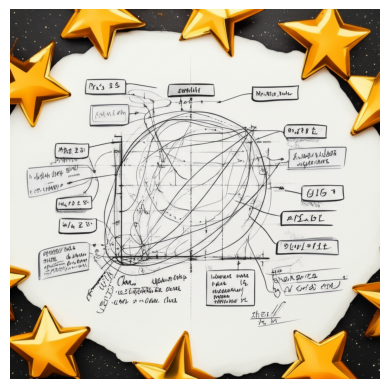

In [55]:
image = chain4.invoke({"article": article, "style": style, "context_and_background": context_and_background})

# Summary

We've built a __multi-modal__ article-helper pipeline. The developed LLM chains help with:
- creating an article title
- summarizing the article
- improving its style
- and genearating an image for it

We've used `LangChain` and `LCEL`.

___
# <span style="color:red"> __Try__ </span>
- Meta llama3.2 via Ollama
___
# <span style="color:red"> __LCEL__ </span>

In [56]:
# # chain1: inputs:article / output:article_title
# chain1 = (
#     {"article": lambda x: x["article"]}
#     | prompt1
#     | llm_creative
#     | {"article_title": lambda x: x.content}
# )
# article_title_msg = chain1.invoke({"article": article})

# f1 = {"article": lambda x: x["article"]}
# f2 = prompt1
# f3 = llm_creative
# f4 = {"article_title": lambda x: x.content}

# step0 = {"article": article}
# print(f'step0: {step0}\n_____________________________')

# step1 = {"article": (lambda x: x["article"]) (step0)}
# print(f'step1: {step1}\n_____________________________')

# step2 = f2.format(article=step1)
# print(f'step2: {step2}\n_____________________________')

# step3 = f3.invoke(step2)
# print(f'step3: {step3}\n_____________________________')

# step4 = {"article_title": (lambda x: x.content) (step3)}
# print(f'step4: {step4}')